In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2


In [35]:
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['PNEUMONIA', 'NORMAL']
Validation classes: ['PNEUMONIA', 'NORMAL']
Test classes: ['PNEUMONIA', 'NORMAL']


In [36]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(150,150), batch_size=32, class_mode='binary')
val_data = val_gen.flow_from_directory(val_dir, target_size=(150,150), batch_size=32, class_mode='binary')
test_data = test_gen.flow_from_directory(test_dir, target_size=(150,150), batch_size=32, class_mode='binary', shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [38]:
base_model = MobileNetV2(
    input_shape=(150,150,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


/tmp/ipykernel_55/593165364.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [40]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stop],
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 417ms/step - accuracy: 0.7563 - loss: 0.6424 - val_accuracy: 0.8125 - val_loss: 0.4738
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.8657 - loss: 0.3085 - val_accuracy: 0.7500 - val_loss: 0.5152
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.8742 - loss: 0.2971 - val_accuracy: 0.8125 - val_loss: 0.5166
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.8895 - loss: 0.2501 - val_accuracy: 0.7500 - val_loss: 0.5552


In [41]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    class_weight=class_weights
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 417ms/step - accuracy: 0.7969 - loss: 0.4898 - val_accuracy: 0.8125 - val_loss: 0.3959
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.8638 - loss: 0.3254 - val_accuracy: 0.8125 - val_loss: 0.3797
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8546 - loss: 0.3236 - val_accuracy: 0.8125 - val_loss: 0.3575
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.8792 - loss: 0.2741 - val_accuracy: 0.8125 - val_loss: 0.3567
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.8956 - loss: 0.2456 - val_accuracy: 0.8750 - val_loss: 0.3351


In [42]:
test_loss, test_acc = model.evaluate(test_data)
print("Final Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8118 - loss: 0.4527
Final Test Accuracy: 0.8541666865348816


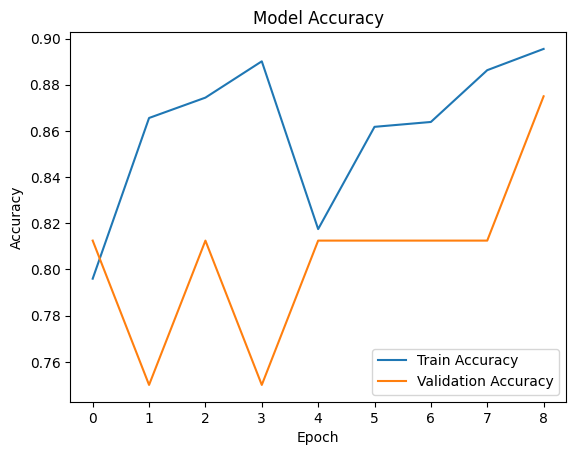

In [43]:
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


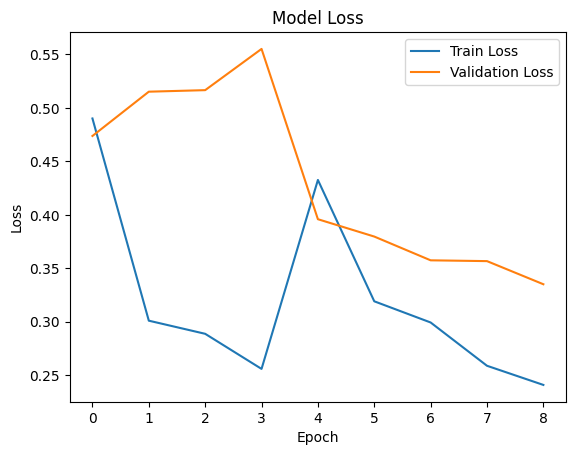

In [44]:
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step


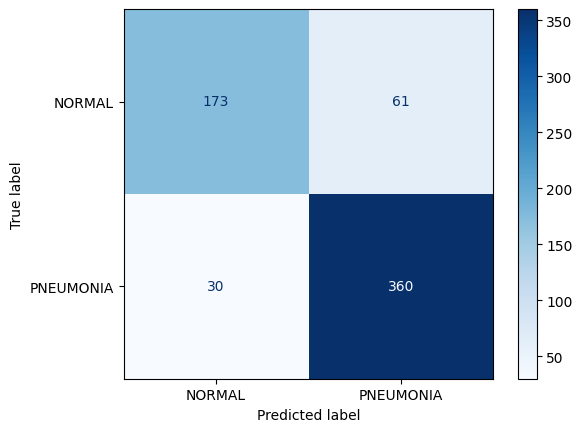

In [45]:
predictions = model.predict(test_data)
y_pred = (predictions > 0.5).astype(int)

cm = confusion_matrix(test_data.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap="Blues")
plt.show()


In [46]:
print(classification_report(test_data.classes, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


              precision    recall  f1-score   support

      NORMAL       0.85      0.74      0.79       234
   PNEUMONIA       0.86      0.92      0.89       390

    accuracy                           0.85       624
   macro avg       0.85      0.83      0.84       624
weighted avg       0.85      0.85      0.85       624



2026-02-08 09:13:09.394230: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 09:13:09.529363: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


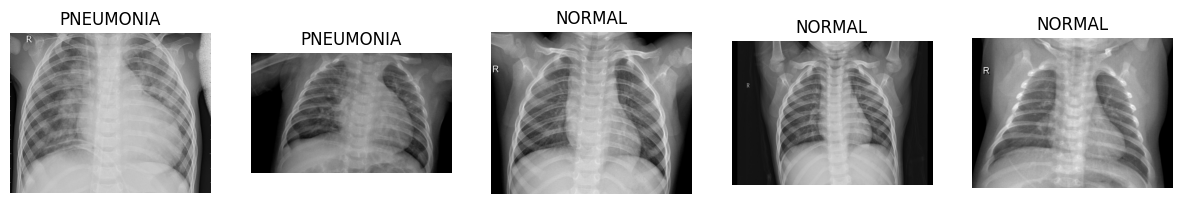

In [47]:
import random

sample_files = random.sample(test_data.filepaths, 5)

plt.figure(figsize=(15,5))

for i, file in enumerate(sample_files):
    img = cv2.imread(file)
    img_resized = cv2.resize(img, (150,150)) / 255.0
    img_array = np.reshape(img_resized, (1,150,150,3))

    pred = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if pred > 0.5 else "NORMAL"

    plt.subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")

plt.show()
